In [1]:
import pandas as pd
import numpy as np
from actionrules.actionRulesDiscovery import ActionRulesDiscovery
import lime.discretize
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from approaches.baseline_rf_wp.utils import prepare_within_project_data, ALL_FEATURES, STATIC_METHOD_FEATURES, STATIC_FILE_FEATURES, STATIC_CLASS_FEATURES 
import warnings
import seaborn as sns
import ast
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')

In [2]:
def check_rule(list_1, list_2):
    all_present = True
    for i in range(len(list_1)):
        if list_2[i] <= list_1[i][1]:
            all_present = True
        else:
            all_present = False
            break
    return all_present

In [3]:
def check_rule_antecedent(list_1, list_2):
    all_present = True
    for i in range(len(list_1)):
        if list_2[i] <= list_1[i][1] and  list_2[i] >= list_1[i][0]:
            all_present = True
        else:
            all_present = False
            break
    return all_present

In [4]:
def hedge(arr1,arr2):
    # returns a value, larger means more changes
    s1,s2 = np.std(arr1),np.std(arr2)
    m1,m2 = np.mean(arr1),np.mean(arr2)
    n1,n2 = len(arr1),len(arr2)
    num = (n1-1)*s1**2 + (n2-1)*s2**2
    denom = n1+n2-1-1
    sp = (num/denom)**.5
    delta = np.abs(m1-m2)/sp
    c = 1-3/(4*(denom)-1)
    return delta*c

In [5]:
def get_actionable_set(train, test, validation, M=5):
    files = [train, test, validation]
#     freq = [0] * train.shape[1]
    deltas = []
    for j in range(0, len(files) - 2):
#         df1 = files[j].iloc[:, 2:]
#         df2 = files[j + 1].iloc[:, 2:]
        
        df1 = files[j]
        df2 = files[j + 1]
        for i in range(1, df1.shape[1]):
            col1 = df1.iloc[:, i]
            col2 = df2.iloc[:, i]
            
            deltas.append(hedge(col1, col2))

    deltas = sorted(range(len(deltas)), key=lambda k: deltas[k], reverse=True)
    actionable = []
    for i in range(0, len(deltas)):
        if i in deltas[0:M]:
            actionable.append(1)
        else:
            actionable.append(0)
            
    slectd_list = [list(df1.columns)[1:-1][i] for i in range(len(df1.columns[1:-1])) if actionable[i] == 1]
    return actionable, slectd_list

In [6]:
def norm (df1,df2):
    # min-max scale the dataset
    X1 = df1.iloc[:,:-1].values
    mm = MinMaxScaler()
    mm.fit(X1)
    X2 = df2.iloc[:,:-1].values
    X2 = mm.transform(X2)
    df2 = df2.copy()
    df2.iloc[:,:-1] = X2
    return df2

In [7]:
def translate1(sentence,name):
    # do not aim to change the column
    lst = sentence.strip().split(name)
    left,right= 0,0
    if lst[0] == '':
        del lst[0]
    if len(lst)==2:
        if '<=' in lst[1]:
            aa=lst[1].strip(' <=')
            right= float(aa)
        elif '<' in lst[1]:
            aa=lst[1].strip(' <')
            right = float(aa)
        if '<=' in lst[0]:
            aa=lst[0].strip(' <=')
            left = float(aa)
        elif '<' in lst[0]:
            aa=lst[0].strip(' <')
            left = float(aa)
    else:
        if '<=' in lst[0]:
            aa=lst[0].strip(' <=')
            right = float(aa)
            left = 0
        elif '<' in lst[0]:
            aa=lst[0].strip(' <')
            right = float(aa)
            left = 0
        if '>=' in lst[0]:
            aa=lst[0].strip(' >=')
            left = float(aa)
            right = 1
        elif '>' in lst[0]:
            aa=lst[0].strip(' >')
            left = float(aa)
            right = 1
    return left, right

In [8]:
def overlap_selection(plan, actual):
    cnt = len(plan.columns)
    same = 0
    metrics = plan.columns
    rest = cnt - len(metrics)
    overlaps = []
    for (_, act) in actual.iterrows():
        for (_, d1), (_, d2) in zip(plan.items(),act.items()):            
            if isinstance(d1.values[0],tuple):
                # The change recommended lie in a range of values
                if d1.values[0][0] <= d2 <= d1.values[0][1]:
                    same +=1 
                    
                elif d2>1:                
                    if d1.values[0][1]>=1:
                        same+=1
                else:
                    if d1.values[0][0]<=0:
                        same+=1
                        
        overlap = (same+rest) / cnt
        overlaps.append(overlap)
        same = 0 
    return np.median(overlaps)

In [9]:
def overlap(plan, actual):
    actual = actual.squeeze()
    cnt = len(plan.columns)
    same = 0
    metrics = plan.columns
    rest = cnt - len(metrics)
    overlaps = []
    for (_, CF) in plan.iterrows():
        for (_, d1), (_, d2) in zip(CF.items(),actual.items()) :
            if isinstance(d1,tuple):
                # The change recommended lie in a range of values
                if d1[0] <= d2 <= d1[1]:
                    same +=1 
                    
                elif d2>1:                
                    if d1[1]>=1:
                        same+=1
                else:
                    if d1[0]<=0:
                        same+=1
                        
        overlap = (same+rest) / cnt
        overlaps.append(overlap)
        same = 0 
    return max(overlaps), overlaps

In [10]:
def abcd(ori, plan, actual, act, columns):
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(ori)):
        if act[i] != 0:
            if isinstance(plan[i], tuple) or isinstance(plan[i], list):
                if plan[i][0] <= actual[i] <= plan[i][1]:
                    tp += 1
                else:
                    fp += 1
            else:
                if plan[i] == actual[i]:
                    tp += 1
                else:
                    fp += 1
        else:
            if isinstance(plan[i], tuple) or isinstance(plan[i], list):
                if plan[i][0] <= actual[i] <= plan[i][1]:
                    tn += 1
                else:
                    fn += 1
            else:
                if plan[i] == actual[i]:
                    tn += 1
                else:
                    fn += 1

    return tp, tn, fp, fn

In [11]:
def merge_recomended_plans_with_origin(plan, test):
    test = test.reset_index(drop=True)
    # Merge the two dataframes based on the common column
    result = [x for x in test.columns if x not in plan.columns]
    
    for col in result:
        plan[col] = np.repeat(test[col].values,plan.shape[0])
        
    return plan

In [12]:
def merge_plan_with_origin(plan, test):
    test = test.reset_index(drop=True)
    # Merge the two dataframes based on the common column
    result = [x for x in test.columns if x not in plan.columns]

    for col in result:
        plan[col] = test[col]
        plan[col] = plan[col].apply(lambda x: (x[0], x[1]))
    return plan

In [13]:
def filter_strings(strings_list, word1, word2):
    """
    Filters a list of strings to return only those that contain both "current" and "max".

    :param strings_list: List of strings.
    :return: Filtered list of strings.
    """
    return [s for s in strings_list if word1 in s and word2 in s]

In [14]:
def merge_by_voting(df):
    # This helper function finds the mode for a series.
    # If the mode computation doesn't produce a clear result, it returns NaN.
    values =[]
    for col in df.columns:
        occurance = df[col].value_counts(dropna=False).idxmax()
        values.append(occurance)
     
    # Apply the custom mode function to each column to get the most common value
    merged = pd.DataFrame(data=[values], columns=df.columns.to_list())
    return merged

# Import the project and process the data

In [15]:
data_all = pd.read_csv('kafka.csv')
data_all['committer_date'] = pd.to_datetime(data_all['committer_date'])

In [16]:
train_df, test_df = prepare_within_project_data(data_all, drop_months_end=3, num_test_commits=250)

In [17]:
test_df

,commit,committer_date,file,oldest_name,change_type,comm,adev,ddev,add,del,...,induces__KAFKA-2517__7cfdf19b54ab60b9644dcbecccb9130d6621da57__2015-10-02 21:46:07,induces__KAFKA-6015__aa1e4c235b882ae98a457cf9176f687951473cee__2017-10-06 22:04:39,induces__KAFKA-2680__9d8dd9f104aef3a9db9005d85bc55a15f851d258__2015-10-31 16:01:59,induces__KAFKA-6566__9e4d50472205ae1f56db7b1a0a2cb5f60d2ab5e4__2018-05-18 17:40:44,induces__KAFKA-4303__6199c62776bf3ce9467703ca651a0119b261e60e__2016-10-14 22:36:43,induces__KAFKA-2902__a5382a333ebb51a10c1a1cab46d66f10abff128a__2015-12-03 02:40:07,induces__KAFKA-5456__f49697a2796540452a21d4a29ab879ba04214046__2017-06-16 19:36:28,induces__KAFKA-2813__8c370093d1ee3b9ba97f85970ec30fbb26ff48ef__2015-11-12 06:18:32,induces__KAFKA-2817__cb0de177cdc03b63ad1927aba1be292ef5637b68__2015-11-13 16:29:36,is_inducing
8145,54a3718a900a5286baf2193713ea8d58ca2c08f6,2017-06-16 01:17:54+01:00,clients/src/main/java/org/apache/kafka/clients...,clients/src/main/java/kafka/clients/producer/K...,ModificationType.MODIFY,109,45,45,0.005865,0.017391,...,0,0,0,0,0,0,0,0,0,False
8146,54a3718a900a5286baf2193713ea8d58ca2c08f6,2017-06-16 01:17:54+01:00,clients/src/main/java/org/apache/kafka/clients...,clients/src/main/java/org/apache/kafka/clients...,ModificationType.ADD,1,1,1,0.173021,0.000000,...,0,0,0,0,0,0,0,0,0,False
8147,54a3718a900a5286baf2193713ea8d58ca2c08f6,2017-06-16 01:17:54+01:00,clients/src/main/java/org/apache/kafka/clients...,clients/src/main/java/kafka/clients/producer/i...,ModificationType.MODIFY,48,17,17,0.002933,0.008696,...,0,0,0,0,0,0,0,0,0,False
8148,54a3718a900a5286baf2193713ea8d58ca2c08f6,2017-06-16 01:17:54+01:00,clients/src/main/java/org/apache/kafka/clients...,clients/src/main/java/kafka/clients/producer/i...,ModificationType.MODIFY,72,25,25,0.055718,0.391304,...,0,0,0,0,0,0,0,0,0,False
8149,54a3718a900a5286baf2193713ea8d58ca2c08f6,2017-06-16 01:17:54+01:00,clients/src/main/java/org/apache/kafka/clients...,clients/src/main/java/kafka/clients/producer/i...,ModificationType.MODIFY,85,23,23,0.020528,0.130435,...,0,0,0,0,0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9384,36556b8041d3647375380e6fd70b8f37ba572ddc,2017-09-29 11:11:12+01:00,streams/src/main/java/org/apache/kafka/streams...,streams/src/main/java/org/apache/kafka/streams...,ModificationType.MODIFY,5,4,4,0.010000,0.076923,...,0,0,0,0,0,0,0,0,0,False
9385,36556b8041d3647375380e6fd70b8f37ba572ddc,2017-09-29 11:11:12+01:00,streams/src/main/java/org/apache/kafka/streams...,streams/src/main/java/org/apache/kafka/streams...,ModificationType.MODIFY,3,3,3,0.030000,0.076923,...,0,0,0,0,0,0,0,0,0,False
9386,36556b8041d3647375380e6fd70b8f37ba572ddc,2017-09-29 11:11:12+01:00,streams/src/main/java/org/apache/kafka/streams...,streams/src/main/java/org/apache/kafka/streams...,ModificationType.MODIFY,17,7,7,0.070000,0.153846,...,0,0,0,0,0,0,0,0,0,False
9387,36556b8041d3647375380e6fd70b8f37ba572ddc,2017-09-29 11:11:12+01:00,streams/src/main/java/org/apache/kafka/streams...,streams/src/main/java/org/apache/kafka/streams...,ModificationType.MODIFY,14,7,7,0.050000,0.153846,...,0,0,0,0,0,0,0,0,0,False


In [18]:
test_df.is_inducing.value_counts(normalize=True)

is_inducing
False    0.920418
True     0.079582
Name: proportion, dtype: float64

In [19]:
metrics = [
    "LOC", "McCC", "LLOC", "LDC", "NOS", "TNOS", "TLLOC", "NLE", "CI", 
    "CD", "NOI", "NUMPAR", "LLDC", "NII", "TCD", "NL", "TLOC", "NLM", 
    "DIT", "NPA", "TNLPM", "TNLA", "NLA", "TNLPA", "NM", "TNG", "NLPM", 
    "TNM", "NOC", "NOD", "NOP", "NLS", "NG", "TNLG", "CBOI", "RFC", 
    "NLG", "TNLS", "TNA", "NLPA", "NOA", "WMC", "NPM", "TNPM", "TNS", 
    "NA", "LCOM5", "NS", "CBO", "TNLM", "TNPA"
]

columns_method = [col for col in train_df.columns if "current_" in col 
           and "_median" in col
           and "_method" in col]
columns_method =  [col for col in columns_method if col.split('_')[1] in metrics]

columns_class = [col for col in train_df.columns if "current_" in col 
           and "_median" in col
           and "_class" in col]
columns_class = [col for col in columns_class if col.split('_')[1] in metrics]

ALL_FEATURES = columns_method + columns_class + ['is_inducing']

In [20]:
len(metrics)

51

In [21]:
train = train_df[ALL_FEATURES]
test = test_df[ALL_FEATURES]

# Metric AutoSpearman on class metric only

In [22]:
columns_class_with_inducing = columns_class + ['is_inducing']
train_df_filter = train_df[columns_class_with_inducing]

In [23]:
# Feature selection using AutoSpearman
from pyexplainer.pyexplainer_pyexplainer import AutoSpearman
# select all rows, and all feature cols
# the last col, which is label col, is not selected
X = train_df_filter.iloc[:, :-1]
total_features = len(X.columns)

# apply feature selection function to our feature DataFrame
X = AutoSpearman(X)
selected = len(X.columns)

# select all rows, and the last label col
y = train.iloc[:, -1]
selected_feature_class = X.columns.to_list()
print(selected, " out of ", total_features, " were selected via AutoSpearman feature selection process")

(Part 1) Automatically select non-correlated metrics based on a Spearman rank correlation test
> Step 1 comparing between current_NOD_class_median and current_NOC_class_median
>> current_NOD_class_median has the average correlation of 0.111 with other metrics
>> current_NOC_class_median has the average correlation of 0.111 with other metrics
>> Exclude current_NOD_class_median
> Step 2 comparing between current_LLDC_class_median and current_LDC_class_median
>> current_LLDC_class_median has the average correlation of 0.231 with other metrics
>> current_LDC_class_median has the average correlation of 0.231 with other metrics
>> Exclude current_LLDC_class_median
> Step 3 comparing between current_LDC_class_median and current_CI_class_median
>> current_LDC_class_median has the average correlation of 0.214 with other metrics
>> current_CI_class_median has the average correlation of 0.213 with other metrics
>> Exclude current_LDC_class_median
> Step 4 comparing between current_NLE_class_medi

> Step 1 - exclude current_NLA_class_median
Finally, according to Part 2 of AutoSpearman, Index(['current_CBO_class_median', 'current_NL_class_median',
       'current_NLS_class_median', 'current_DIT_class_median',
       'current_TNLG_class_median', 'current_CI_class_median', 'const',
       'current_TNLPA_class_median', 'current_TNLPM_class_median',
       'current_TCD_class_median', 'current_LCOM5_class_median',
       'current_NOC_class_median', 'current_CBOI_class_median'],
      dtype='object') are selected.
12  out of  49  were selected via AutoSpearman feature selection process


# Metric AutoSpearman on methode metric only

In [24]:
columns_method_with_inducing = columns_method + ['is_inducing']
train_df_filter = train_df[columns_method_with_inducing]

In [25]:
from pyexplainer.pyexplainer_pyexplainer import AutoSpearman
# select all rows, and all feature cols
# the last col, which is label col, is not selected
X = train_df_filter.iloc[:, :-1]
total_features = len(X.columns)

# apply feature selection function to our feature DataFrame
X = AutoSpearman(X)
selected_feature_method =  X.columns.tolist()
selected_feature_method.append('current_McCC_method_median')
# select all rows, and the last label col
y = train_df_filter.iloc[:, -1]

print(len(X.columns), " out of ", total_features, " were selected via AutoSpearman feature selection process")
print('feature cols:', '\n\n', X.head(1), '\n\n')
print('label col:', '\n\n', X.columns.tolist())

selected_feature_method

(Part 1) Automatically select non-correlated metrics based on a Spearman rank correlation test
> Step 1 comparing between current_LLDC_method_median and current_LDC_method_median
>> current_LLDC_method_median has the average correlation of 0.169 with other metrics
>> current_LDC_method_median has the average correlation of 0.169 with other metrics
>> Exclude current_LDC_method_median
> Step 2 comparing between current_CI_method_median and current_LLDC_method_median
>> current_CI_method_median has the average correlation of 0.11 with other metrics
>> current_LLDC_method_median has the average correlation of 0.11 with other metrics
>> Exclude current_LLDC_method_median
> Step 3 comparing between current_NL_method_median and current_NLE_method_median
>> current_NL_method_median has the average correlation of 0.456 with other metrics
>> current_NLE_method_median has the average correlation of 0.455 with other metrics
>> Exclude current_NL_method_median
> Step 4 comparing between current_LO

['current_TLOC_method_median',
 'current_TCD_method_median',
 'current_NLE_method_median',
 'current_CI_method_median',
 'current_NOI_method_median',
 'current_NUMPAR_method_median',
 'current_NII_method_median',
 'current_McCC_method_median']

In [26]:
# Merge the class and method recomended features by autospearmen features
ALL_FEATURES_FILTRED = selected_feature_class + selected_feature_method +["is_inducing"]

# Model evaluation , Feature importance 

In [27]:
# 2. Load dataset
X = train_df_filter.iloc[:, :-1]
y = train_df_filter.iloc[:, -1]


# 3. Preprocess the data (In this case, Iris dataset is already preprocessed)

# 4. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Apply SMOTE to the training data
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# 6. Train the Random Forest classifier on the resampled data
clf = RandomForestClassifier(n_estimators=30, max_depth=32,
                            min_samples_leaf=8,random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# 7. (Optional) Evaluate the model using F1 score
y_pred = clf.predict(X_test)

# 8. Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1 Score: {f1:.4f}")

Accuracy: 79.84%
F1 Score: 0.6073


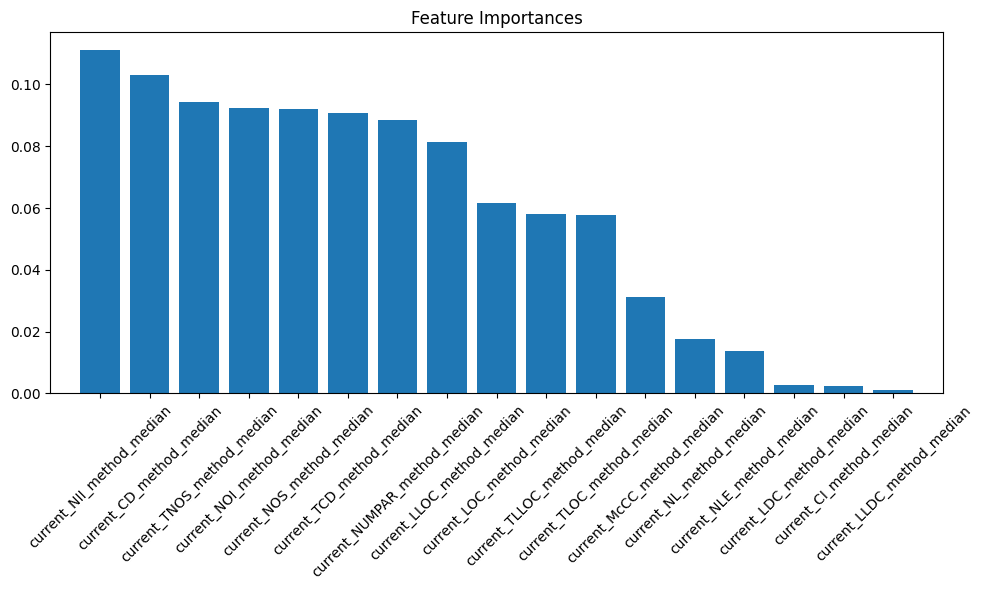

In [28]:
# Get feature importances
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10,6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), np.array(X_train_resampled.columns)[indices], rotation=45)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

# Define the stable and felexible attributes

In [29]:
# Remove the column that are not recomended by autospearmen
train = train[ALL_FEATURES_FILTRED]
test = test[ALL_FEATURES_FILTRED] 

In [30]:
# Split the DataFrame into three equal parts only on the train set. 
# We are going to evaluate the varaince of the features using hedge between the three DataFrames
dfs = np.array_split(train, 3)

In [31]:
#Apply hedge and identify the top 10 actionable features
actionable, actionable_name = get_actionable_set(dfs[0], dfs[1], dfs[2], M=11)

In [32]:
# Extrcat the stable attribute: The stable attribute are the columns that are not selected by hedge
stable_name  = [col for col in ALL_FEATURES_FILTRED[:-1] if col not in actionable_name]

In [33]:
x_train = train.copy()
x_test = test.copy()

In [99]:
train

,current_CBO_class_median,current_NL_class_median,current_NLS_class_median,current_DIT_class_median,current_TNLG_class_median,current_CI_class_median,current_TNLPA_class_median,current_TNLPM_class_median,current_TCD_class_median,current_LCOM5_class_median,...,current_CBOI_class_median,current_TLOC_method_median,current_TCD_method_median,current_NLE_method_median,current_CI_method_median,current_NOI_method_median,current_NUMPAR_method_median,current_NII_method_median,current_McCC_method_median,is_inducing
0,3.0,4.0,0.0,0.0,7.0,0.0,0.0,11.0,0.142857,1.0,...,1.0,11.5,0.000000,0.5,0.0,1.0,0.5,1.0,2.0,True
1,3.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.000000,1.0,...,1.0,4.0,0.000000,0.0,0.0,0.0,2.0,0.0,1.0,False
2,4.0,5.0,1.0,0.0,1.0,2.0,1.0,4.0,0.126050,1.0,...,1.0,14.5,0.052325,0.5,0.0,1.0,2.5,1.0,1.5,False
3,0.0,5.0,0.0,0.0,3.0,0.0,0.0,11.0,0.044776,1.0,...,6.0,5.0,0.000000,0.0,0.0,0.0,1.0,0.0,1.0,False
4,4.0,4.0,0.0,0.0,2.0,0.0,0.0,6.0,0.062992,3.0,...,1.0,12.0,0.000000,1.0,0.0,2.0,0.0,0.0,2.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6737,6.5,1.0,0.0,1.0,0.0,0.0,0.0,3.5,0.000000,2.5,...,1.0,4.0,0.000000,0.0,0.0,1.0,2.0,0.0,1.0,True
6738,5.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,0.150000,3.0,...,1.0,4.0,0.000000,0.0,0.0,1.0,2.0,2.0,1.0,False
6739,5.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,0.150000,3.0,...,1.0,4.0,0.000000,0.0,0.0,1.0,2.0,2.0,1.0,False
6740,5.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.090909,1.0,...,1.0,4.0,0.440000,0.0,0.0,1.0,1.0,1.0,1.0,False


# Apply Smote to Balance the data

In [34]:
from imblearn.over_sampling import SMOTE
# Apply SMOTE
X = x_train.iloc[:,:-1]
Y = x_train["is_inducing"]

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, Y)

# Convert the resampled data back to a dataframe
x_train_resampled = pd.DataFrame(X_resampled, columns=x_train.columns[:-1])
x_train_resampled['is_inducing'] = y_resampled

# Normalize the data

In [35]:
# X_train_norm = norm(x_train, x_train_resampled)
# X_test_norm = norm(x_train, x_test)

X_train_norm = x_train_resampled.copy()
X_test_norm =  x_test.copy()

# Desritize the data using Entroty descritization of Lime

In [36]:
desc = lime.discretize.EntropyDiscretizer(X_train_norm.iloc[:, :-1].values,
                                          categorical_features=[],labels=X_train_norm.iloc[:,-1].values,
                                                   feature_names=X_train_norm.iloc[:, :-1].columns )
discretized_training_data = desc.discretize(X_train_norm.values)

names = desc.names

In [37]:
mapping_tuple = {}

for i in range(X_train_norm.iloc[:, :-1].columns.shape[0]) :
    col = X_train_norm.iloc[:, :-1].columns[i]
    tuples = {}
    for index, value in enumerate(names[i]):
        left, right = translate1(value, col)
        tuples[index] = (left, right)
    mapping_tuple[col] = tuples

In [38]:
discretized_training_data = pd.DataFrame(discretized_training_data, columns=X_train_norm.columns)
for key, values in mapping_tuple.items():
    discretized_training_data[key] = discretized_training_data[key].map(values)

In [100]:
train_df

,commit,committer_date,file,oldest_name,change_type,comm,adev,ddev,add,del,...,induces__KAFKA-3122__9059bbfff917b4bebbb06f8c8a01cce3d8230830__2016-01-20 06:50:33,induces__KAFKA-5206__e40e27b4eb99e8931488e86289453c5f14d5e886__2017-05-15 18:18:12,induces__KAFKA-3784__c0537b5f059e025fa268d92a58c27d98540b7c5a__2016-06-03 20:22:00,induces__KAFKA-2517__7cfdf19b54ab60b9644dcbecccb9130d6621da57__2015-10-02 21:46:07,induces__KAFKA-2680__9d8dd9f104aef3a9db9005d85bc55a15f851d258__2015-10-31 16:01:59,induces__KAFKA-4303__6199c62776bf3ce9467703ca651a0119b261e60e__2016-10-14 22:36:43,induces__KAFKA-2902__a5382a333ebb51a10c1a1cab46d66f10abff128a__2015-12-03 02:40:07,induces__KAFKA-2813__8c370093d1ee3b9ba97f85970ec30fbb26ff48ef__2015-11-12 06:18:32,induces__KAFKA-2817__cb0de177cdc03b63ad1927aba1be292ef5637b68__2015-11-13 16:29:36,is_inducing
0,642da2f28c9bc6e373603d6d9119ce33684090f5,2011-08-01 23:41:24+00:00,contrib/hadoop-consumer/src/main/java/kafka/et...,contrib/hadoop-consumer/src/main/java/kafka/et...,ModificationType.ADD,1,1,1,0.003701,0.000000,...,0,0,0,0,0,0,0,0,0,True
1,642da2f28c9bc6e373603d6d9119ce33684090f5,2011-08-01 23:41:24+00:00,contrib/hadoop-consumer/src/main/java/kafka/et...,contrib/hadoop-consumer/src/main/java/kafka/et...,ModificationType.ADD,1,1,1,0.000836,0.000000,...,0,0,0,0,0,0,0,0,0,False
2,642da2f28c9bc6e373603d6d9119ce33684090f5,2011-08-01 23:41:24+00:00,contrib/hadoop-consumer/src/main/java/kafka/et...,contrib/hadoop-consumer/src/main/java/kafka/et...,ModificationType.ADD,1,1,1,0.002139,0.000000,...,0,0,0,0,0,0,0,0,0,False
3,642da2f28c9bc6e373603d6d9119ce33684090f5,2011-08-01 23:41:24+00:00,contrib/hadoop-consumer/src/main/java/kafka/et...,contrib/hadoop-consumer/src/main/java/kafka/et...,ModificationType.ADD,1,1,1,0.001206,0.000000,...,0,0,0,0,0,0,0,0,0,False
4,642da2f28c9bc6e373603d6d9119ce33684090f5,2011-08-01 23:41:24+00:00,contrib/hadoop-consumer/src/main/java/kafka/et...,contrib/hadoop-consumer/src/main/java/kafka/et...,ModificationType.ADD,1,1,1,0.002248,0.000000,...,0,0,0,0,0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6737,9e4548df30d50a56ae99cb3383f1a3f97bbe77bb,2017-03-14 14:21:03-07:00,streams/src/main/java/org/apache/kafka/streams...,streams/src/main/java/org/apache/kafka/streams...,ModificationType.MODIFY,4,3,3,0.022624,0.014523,...,0,0,0,0,0,0,0,0,0,True
6738,52a15d7c0b88da11409954321463b8b57b133a23,2017-03-14 17:20:49-07:00,connect/runtime/src/main/java/org/apache/kafka...,connect/runtime/src/main/java/org/apache/kafka...,ModificationType.ADD,1,1,1,0.356164,0.000000,...,0,0,0,0,0,0,0,0,0,False
6739,962c378cc6cdb178541155af419c24e463516a5d,2017-03-15 14:46:32+00:00,connect/runtime/src/main/java/org/apache/kafka...,connect/runtime/src/main/java/org/apache/kafka...,ModificationType.MODIFY,2,2,2,0.545455,0.545455,...,0,0,0,0,0,0,0,0,0,False
6740,b9f812491f5eb06ffe5b68f5e53df4302d2f68a8,2017-03-15 10:46:57-07:00,streams/src/main/java/org/apache/kafka/streams...,streams/src/main/java/org/apache/kafka/streams...,ModificationType.MODIFY,41,13,13,0.500000,0.258065,...,0,0,0,0,0,0,0,0,0,False


In [96]:
discretized_training_data

,current_CBO_class_median,current_NL_class_median,current_NLS_class_median,current_DIT_class_median,current_TNLG_class_median,current_CI_class_median,current_TNLPA_class_median,current_TNLPM_class_median,current_TCD_class_median,current_LCOM5_class_median,...,current_CBOI_class_median,current_TLOC_method_median,current_TCD_method_median,current_NLE_method_median,current_CI_method_median,current_NOI_method_median,current_NUMPAR_method_median,current_NII_method_median,current_McCC_method_median,is_inducing
0,"(2.0, 1)","(1.0, 1)","(0, 0.0)","(0, 0.0)","(0.5, 1)","(0, 1.0)","(0, 0.0)","(10.0, 1)","(0.0, 0.63)","(0.01, 2.0)",...,"(0.0, 1.5)","(4.5, 1)","(0, 0.0)","(0.5, 0.5)","(0, 0.01)","(0.5, 1.0)","(0.5, 2.0)","(0.5, 3.0)","(1.5, 1)",True
1,"(2.0, 1)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0.5, 1)","(0, 1.0)","(0, 0.0)","(0.01, 4.0)","(0, 0.0)","(0.01, 2.0)",...,"(0.0, 1.5)","(3.5, 4.0)","(0, 0.0)","(0, 0.0)","(0, 0.01)","(0, 0.0)","(2.0, 1)","(0, 0.0)","(0.94, 1.0)",False
2,"(2.0, 1)","(1.0, 1)","(0.99, 1.61)","(0, 0.0)","(0.5, 1)","(1.0, 3.0)","(0.5, 7.8)","(4.0, 9.0)","(0.0, 0.63)","(0.01, 2.0)",...,"(0.0, 1.5)","(4.5, 1)","(0.0, 0.25)","(0.5, 0.5)","(0, 0.01)","(0.5, 1.0)","(2.0, 1)","(0.5, 3.0)","(1.5, 1.5)",False
3,"(0, 0.0)","(1.0, 1)","(0, 0.0)","(0, 0.0)","(0.5, 1)","(0, 1.0)","(0, 0.0)","(10.0, 1)","(0.0, 0.63)","(0.01, 2.0)",...,"(2.01, 1)","(4.5, 1)","(0, 0.0)","(0, 0.0)","(0, 0.01)","(0, 0.0)","(0.5, 2.0)","(0, 0.0)","(0.94, 1.0)",False
4,"(2.0, 1)","(1.0, 1)","(0, 0.0)","(0, 0.0)","(0.5, 1)","(0, 1.0)","(0, 0.0)","(4.0, 9.0)","(0.0, 0.63)","(3.0, 13.03)",...,"(0.0, 1.5)","(4.5, 1)","(0, 0.0)","(0.5, 1)","(0, 0.01)","(1.0, 1)","(0, 0.0)","(0, 0.0)","(1.5, 1)",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11843,"(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 1.0)","(0.0, 0.5)","(0.01, 4.0)","(0, 0.0)","(0, 0.01)",...,"(2.0, 2.01)","(3.0, 3.5)","(0, 0.0)","(0, 0.0)","(0, 0.01)","(0.0, 0.5)","(0.5, 2.0)","(0.5, 3.0)","(0.94, 1.0)",True
11844,"(2.0, 1)","(1.0, 1)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 1.0)","(0, 0.0)","(4.0, 9.0)","(0.0, 0.63)","(0.01, 2.0)",...,"(2.01, 1)","(2.0, 3.0)","(0.25, 0.56)","(0, 0.0)","(0, 0.01)","(0, 0.0)","(0, 0.0)","(0.5, 3.0)","(0.94, 1.0)",True
11845,"(2.0, 1)","(1.0, 1)","(0, 0.0)","(0, 0.0)","(0.5, 0.5)","(0, 1.0)","(0, 0.0)","(10.0, 1)","(0.0, 0.63)","(0.01, 2.0)",...,"(2.01, 1)","(2.0, 3.0)","(0, 0.0)","(0, 0.0)","(0, 0.01)","(0, 0.0)","(0.5, 2.0)","(3.0, 1)","(0.94, 1.0)",True
11846,"(2.0, 1)","(1.0, 1)","(0, 0.0)","(0.5, 2.0)","(0, 0.0)","(0, 1.0)","(0, 0.0)","(10.0, 1)","(0.0, 0.63)","(2.0, 3.0)",...,"(2.01, 1)","(4.0, 4.5)","(0, 0.0)","(0, 0.0)","(0, 0.01)","(0.5, 1.0)","(0.0, 0.5)","(0, 0.0)","(0.94, 1.0)",True


# Apply Action rule algorithm using the default paramaters

In [39]:
actionRulesDiscovery_3 = ActionRulesDiscovery()
actionRulesDiscovery_3.load_pandas(discretized_training_data)

print('-------- Action rules from random forest start ----------')
actionRulesDiscovery_3.fit(
                         stable_attributes=stable_name,
                         flexible_attributes=actionable_name,
                         consequent="is_inducing",
                         conf=55,
                         supp=5,
                         desired_classes=[False],
                         is_nan=False,
                         is_reduction=True,
                         min_stable_attributes=1,
                         min_flexible_attributes=1
                          )
for rule in actionRulesDiscovery_3.get_action_rules_representation():
    print(rule)

-------- Action rules from random forest start ----------
r = [(current_McCC_method_median: (0.94, 1.0)) ∧ (current_TLOC_method_median: (4.5, 1) → (0.79, 1.01))  ∧ (current_LCOM5_class_median: (0.01, 2.0) → (0, 0.01)) ] ⇒ [is_inducing: True → False] with support: 0.055452397029034435, confidence: 0.5137712588541729, uplift: 0.09622480830112705.
r = [(current_McCC_method_median: (0.94, 1.0)) ∧ (current_LCOM5_class_median: (0.01, 2.0) → (0, 0.01))  ∧ (current_CBOI_class_median: (0.0, 1.5) → (0, 0.0)) ] ⇒ [is_inducing: True → False] with support: 0.07030722484807563, confidence: 0.4799875474047659, uplift: 0.06364774320885057.
r = [(current_McCC_method_median: (0.94, 1.0)) ∧ (current_TCD_class_median: (0.0, 0.63) → (0, 0.0))  ∧ (current_LCOM5_class_median: (0.01, 2.0) → (0, 0.01))  ∧ (current_CBOI_class_median: (0.0, 1.5) → (0, 0.0)) ] ⇒ [is_inducing: True → False] with support: 0.05114787305874409, confidence: 0.4767442778683702, uplift: 0.03785856543398064.
r = [(current_McCC_method_med

# Evaluating the Action Rules using the confidence, support and Lift

In [40]:
fixes = x_train[x_train.is_inducing==False]

In [41]:
action_rules = actionRulesDiscovery_3.get_action_rules()
formatted_rules = list()
columns = [
    "change_metric_(cause)",
    "target_value_change_(consequence)",
    'support',
    'confidence',
    'lift'
]

for rule in action_rules:
    precedent = [ast.literal_eval(x[1][0]) for x in rule[0][1]]
    antecedent = [ast.literal_eval(x[1][1]) for x in rule[0][1]]
    columns_causes = [x[0] for x in rule[0][1]]           
    
    cause = ['{}: {}'.format(x[0], x[1]) for x in rule[0][1]]
    consequence = '{}: {}'.format(rule[0][2][0], tuple(rule[0][2][1]))
    support = rule[1][2]
    confidence = rule[2][2]
    lift = rule[3]
    formatted_rules.append([
        cause,
        consequence,
        support,
        confidence,
        lift
    ])
    
formatted_rules = pd.DataFrame(formatted_rules, columns=columns).sort_values('support',ascending=False).reset_index(drop=True)

In [42]:
formatted_rules.to_csv('nifi_rules.csv',index=False)

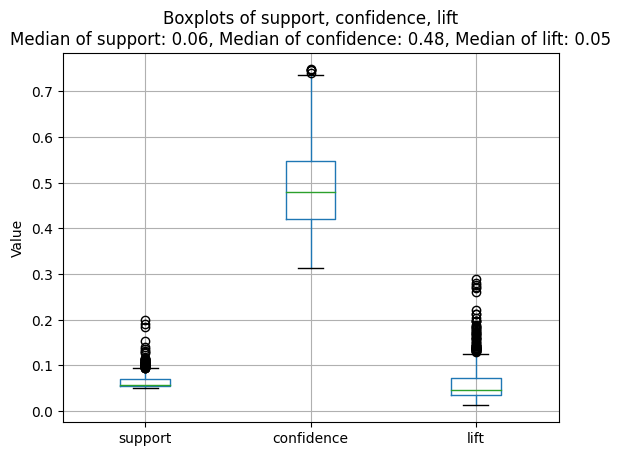

In [43]:
# Calculate medians
median_support = formatted_rules['support'].median()
median_confidence = formatted_rules['confidence'].median()
median_lift = formatted_rules['lift'].median()

# Plot
formatted_rules.boxplot(column=['support','confidence','lift'])

# Setting the title with medians
plt.title(f'Boxplots of support, confidence, lift\nMedian of support: {median_support:.2f}, Median of confidence: {median_confidence:.2f}, Median of lift: {median_lift:.2f}')
plt.ylabel('Value')
plt.show()

# Description of the plot:

**High Confidence**: The majority of the rules generated by the algorithm have a high confidence. This indicates that the conditional probability of the consequent occurring given the antecedent is generally high. In other words, when the conditions of the rule are met, it's very likely that the outcome predicted by the rule will happen.

**Variable Support**: The support for these rules varies significantly, with a higher concentration of rules having low support. This suggests that while many rules are quite specific (applying to only a small portion of all transactions), they are still reliable when their conditions are met (as indicated by the high confidence).

**High Lift**: The rules tend to have a high lift value, implying that the occurrence of the antecedent increases the chances of the consequent happening more than if they were independent. This means that the rules aren't just capturing frequent patterns, but also patterns that have a meaningful relationship.

In summary, the action rule algorithm seems to be generating rules that, while might be based on less frequent patterns (low support), are highly predictive (high confidence) and indicate a meaningful relationship rather than mere coincidence (high lift). This could be particularly useful in scenarios where it's important to identify specific, impactful patterns rather than just the most common ones.

# Test the Action rule algorithm

# Descritize the test Data

In [44]:
# Descritize the test data using the same range of values for the train data
discretized_test_data = desc.discretize(X_test_norm.values)
discretized_test_data = pd.DataFrame(discretized_test_data, columns=X_test_norm.columns)
for key, values in mapping_tuple.items():
    discretized_test_data[key] = discretized_test_data[key].map(values)

In [45]:
# To identify the commit we add the date, file and commit id to the test set. This is useful when we need to look 
# for the commit in Github
X_test_norm.insert(0,'committer_date', test_df['committer_date'])
X_test_norm.insert(0,'file', test_df['file'])
X_test_norm.insert(0,'commit', test_df['commit'])

In [46]:
# Select the defective files
defected_files = list(X_test_norm[X_test_norm.is_inducing==True].file)

# For each bug in the test set identify it's correspandent fix

In [47]:
# Initialize an empty list to store the results
# This code is designed to detect defective bugs and their corresponding fixes.
# If a commit targets the same file and follows a buggy commit, and if it's not defective, 
# then it's considered as a fix for the defective commit.

defects = []
actuals = []
for file in defected_files:
    test_ac = X_test_norm[X_test_norm.file==file].copy()
    inducing_rows = test_ac[test_ac.is_inducing==True]
    # Loop over the inducing rows
    for i, row in inducing_rows.iterrows():
        # Find the closest row with is_inducing == False and a later date
        closest_false_row = test_ac[(test_ac['is_inducing'] == False) & (test_ac['committer_date'] > row['committer_date'])].sort_values('committer_date', ascending=True)

        # Append the result to the list if a match was found
        if not closest_false_row.empty:
            defects.append(row)
            actuals.append(closest_false_row.iloc[0])

In [48]:
defects_df = pd.DataFrame(defects, columns=test_ac.columns).reset_index(drop=True)
actuals_df = pd.DataFrame(actuals, columns=test_ac.columns).reset_index(drop=True)

# Descritize the defective commits in the test data.

In [49]:
discretized_test_data = desc.discretize(defects_df.iloc[:,3:-1].values)
discretized_test_data = pd.DataFrame(discretized_test_data, columns=defects_df.iloc[:,3:-1].columns)
for key, values in mapping_tuple.items():
    discretized_test_data[key] = discretized_test_data[key].map(values)

In [50]:
discretized_test_data.head()

,current_CBO_class_median,current_NL_class_median,current_NLS_class_median,current_DIT_class_median,current_TNLG_class_median,current_CI_class_median,current_TNLPA_class_median,current_TNLPM_class_median,current_TCD_class_median,current_LCOM5_class_median,current_NOC_class_median,current_CBOI_class_median,current_TLOC_method_median,current_TCD_method_median,current_NLE_method_median,current_CI_method_median,current_NOI_method_median,current_NUMPAR_method_median,current_NII_method_median,current_McCC_method_median
0,"(2.0, 1)","(1.0, 1)","(0, 0.0)","(0.5, 2.0)","(0, 0.0)","(0, 1.0)","(0, 0.0)","(0.01, 4.0)","(0.0, 0.63)","(3.0, 13.03)","(0, 0.0)","(0, 0.0)","(4.5, 1)","(0, 0.0)","(0.5, 1)","(0, 0.01)","(1.0, 1)","(0.5, 2.0)","(0, 0.0)","(1.5, 1)"
1,"(2.0, 1)","(1.0, 1)","(0, 0.0)","(0.5, 2.0)","(0, 0.0)","(0, 1.0)","(0, 0.0)","(0.01, 4.0)","(0.0, 0.63)","(3.0, 13.03)","(0, 0.0)","(0, 0.0)","(4.5, 1)","(0, 0.0)","(0.5, 1)","(0, 0.01)","(1.0, 1)","(0.5, 2.0)","(0, 0.0)","(1.5, 1)"
2,"(2.0, 1)","(1.0, 1)","(0, 0.0)","(0.5, 2.0)","(0, 0.0)","(0, 1.0)","(0, 0.0)","(0.01, 4.0)","(0.0, 0.63)","(3.0, 13.03)","(0, 0.0)","(0, 0.0)","(4.5, 1)","(0, 0.0)","(0.5, 1)","(0, 0.01)","(1.0, 1)","(0.5, 2.0)","(0, 0.0)","(1.5, 1)"
3,"(2.0, 1)","(1.0, 1)","(0, 0.0)","(0.5, 2.0)","(0, 0.0)","(0, 1.0)","(0, 0.0)","(0.01, 4.0)","(0.0, 0.63)","(3.0, 13.03)","(0, 0.0)","(0, 0.0)","(4.5, 1)","(0, 0.0)","(0.5, 1)","(0, 0.01)","(1.0, 1)","(0.5, 2.0)","(0, 0.0)","(1.5, 1)"
4,"(2.0, 1)","(1.0, 1)","(0, 0.0)","(0.5, 2.0)","(0, 0.0)","(0, 1.0)","(0, 0.0)","(0.01, 4.0)","(0.0, 0.63)","(3.0, 13.03)","(0, 0.0)","(0, 0.0)","(4.5, 1)","(0, 0.0)","(0.5, 1)","(0, 0.01)","(0.5, 1.0)","(0.5, 2.0)","(0, 0.0)","(1.5, 1)"


# Plan selection of CF by comupting the overlap with historical data and example on 1 defect

In [51]:
defect = discretized_test_data.iloc[0].to_frame().T

plan = actionRulesDiscovery_3.predict(defect)
plan_recomendation = plan.filter(regex='recommended')

columns = [s.replace('-recommended', "") for s in plan_recomendation.columns]


# Impute the missing data,if the value is Nan it mean you don't change it so with fill it with the original value
for col in columns:

        plan_recomendation['{}-recommended'.format(col)] = plan_recomendation['{}-recommended'.format(col)].apply(lambda 
                                                                                          x:defect[col].values[0]
                                                                                          if x is np.nan 
                                                                                        else x)


# ADD the not changed metrics to the plan to compute the overlap
plan_recomendation.columns = columns


plan_recomendation = merge_recomended_plans_with_origin(plan_recomendation, defect)

plan_recomendation = plan_recomendation.reindex(columns=defect.columns.to_list())
plan_recomendation['support after'] =  plan['support after']
plan_recomendation['confidence after'] =  plan['confidence after']
plan_recomendation.drop_duplicates(subset=columns, inplace=True)

overlaps = []
for j in tqdm(range(plan_recomendation.shape[0])):
    test = plan_recomendation.iloc[j].to_frame().T
    overlap_value = overlap_selection(test[defect.columns],actuals_df[defect.columns])
    overlaps.append(overlap_value)
    
plan_recomendation['overlap'] = overlaps

#return the plan with the highest overlap
plan_to_recomend = plan_recomendation[plan_recomendation["overlap"] == max(overlaps)].sample()

100%|██████████| 9/9 [00:00<00:00, 55.11it/s]


# Select plan

In [51]:
def predict_and_select_paln(defect, history_data):

    plan = actionRulesDiscovery_3.predict(defect)
    plan_recomendation = plan.filter(regex='recommended')

    columns = [s.replace('-recommended', "") for s in plan_recomendation.columns]


    # Impute the missing data,if the value is Nan it mean you don't change it so with fill it with the original value
    for col in columns:

            plan_recomendation['{}-recommended'.format(col)] = plan_recomendation['{}-recommended'.format(col)].apply(lambda 
                                                                                              x:defect[col].values[0]
                                                                                              if x is np.nan 
                                                                                            else x)


    # ADD the not changed metrics to the plan to compute the overlap
    plan_recomendation.columns = columns


    plan_recomendation = merge_recomended_plans_with_origin(plan_recomendation, defect)

    plan_recomendation = plan_recomendation.reindex(columns=defect.columns.to_list())
    plan_recomendation['support after'] =  plan['support after']
    plan_recomendation['confidence after'] =  plan['confidence after']
    plan_recomendation.drop_duplicates(subset=columns, inplace=True)
    plan_recomendation.drop_duplicates(inplace=True)

    overlaps = []
    for j in range(plan_recomendation.shape[0]):
        test = plan_recomendation.iloc[j].to_frame().T
        overlap = overlap_selection(test[defect.columns],history_data[defect.columns])
        overlaps.append(overlap)

    plan_recomendation['overlap'] = overlaps

    #return the plan with the highest overlap
    plan_to_recomend = plan_recomendation[plan_recomendation["overlap"] == max(overlaps)].sample()
    return plan_to_recomend

# Computing Overlap , after Plan selection using the overlap with historical code change, compute the actual overlap of every defect with it's correspanding fix and finally computing the precision and recall

In [ ]:
plans_overlap = []
matrix=[]
confidence = []
support = []
history_data = train[train.is_inducing==False]
actuals_df.drop(columns=['committer_date'],inplace=True)
for i in tqdm(range(discretized_test_data.shape[0])):
    defect = discretized_test_data.iloc[i].to_frame().T
    actual = actuals_df.iloc[i].iloc[2:-1].to_frame().T

    
    #In this line we select the CF by computing the overlap with the historical dataset
    try:
        plan_recomendation = predict_and_select_paln(defect, history_data)
    except:
        continue
    confidence.append(plan_recomendation['confidence after'])
    support.append(plan_recomendation['support after'])
    
    overlap_value , list_overlap = overlap(plan_recomendation.drop(columns=['overlap']), actual)
    plans_overlap.append(overlap_value)
    
    tp, tn, fp, fn = abcd(defect.values[0], plan_recomendation.values[0], actual.values[0], actionable,plan_recomendation.columns)
    matrix.append([tp, tn, fp, fn])


 57%|█████▋    | 84/148 [1:36:25<1:41:37, 95.27s/it] 

In [122]:
print(np.mean(plans_overlap))

0.8583148558758315


In [123]:
TP = np.median([lst[0] for lst in matrix])
TN = np.median([lst[1] for lst in matrix])
FP = np.median([lst[2] for lst in matrix])
FN = np.median([lst[3] for lst in matrix])
print('recal is {}'.format(np.round(TP / (TP + FN), 2) * 100))
print('Precision is {}'.format(np.round(TP / (TP + FP), 2) * 100))

recal is 71.0
Precision is 91.0


In [124]:
np.median(support)

0.0675219446320054

In [125]:
np.median(confidence)

0.7132188200149365

In [126]:
precision_recall = pd.DataFrame(matrix, columns=['TP','TN','FP','FN'])

In [127]:
precision_recall.to_csv('nifi_precision_recall.csv',index=False)